In [18]:
import numpy as np
import os
import sys
import math

# ----- class for snapshot header ----- 

class snapshot_header:
    def __init__(self, filename):
        if (not os.path.exists(filename)):
            print("file not found:", filename)
            sys.exit()
      
        self.filename = filename  
        f = open(filename,'rb')    
        blocksize = np.fromfile(f,dtype=np.int32,count=1)
        if blocksize[0] == 8:
            swap = 0
            format = 2
        elif blocksize[0] == 256:
            swap = 0
            format = 1  
        else:
            blocksize.byteswap(True)
            if blocksize[0] == 8:
                swap = 1
                format = 2
            elif blocksize[0] == 256:
                swap = 1
                format = 1
            else:
                print("incorrect file format encountered when reading header of", filename)
                sys.exit()
    
        self.format = format
        self.swap = swap
    
        if format==2:
            f.seek(16, os.SEEK_CUR)
    
        self.npart = np.fromfile(f,dtype=np.int32,count=6)
        self.massarr = np.fromfile(f,dtype=np.float64,count=6)
        self.time = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.redshift = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.sfr = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.feedback = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.nall = np.fromfile(f,dtype=np.int32,count=6)
        self.cooling = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.filenum = (np.fromfile(f,dtype=np.int32,count=1))[0]
        self.boxsize = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_m = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.omega_l = (np.fromfile(f,dtype=np.float64,count=1))[0]
        self.hubble = (np.fromfile(f,dtype=np.float64,count=1))[0]
    
        if swap:
            self.npart.byteswap(True)
            self.massarr.byteswap(True)
            self.time = self.time.byteswap()
            self.redshift = self.redshift.byteswap()
            self.sfr = self.sfr.byteswap()
            self.feedback = self.feedback.byteswap()
            self.nall.byteswap(True)
            self.cooling = self.cooling.byteswap()
            self.filenum = self.filenum.byteswap()
            self.boxsize = self.boxsize.byteswap()
            self.omega_m = self.omega_m.byteswap()
            self.omega_l = self.omega_l.byteswap()
            self.hubble = self.hubble.byteswap()
     
        f.close()
 


#----- find offset and size of data block ----- 

def find_block(filename, format, swap, block, block_num, only_list_blocks=False):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
            
    f = open(filename,'rb')
    f.seek(0, os.SEEK_END)
    filesize = f.tell()
    f.seek(0, os.SEEK_SET)
  
    found = False
    curblock_num = 1
    while ((not found) and (f.tell()<filesize)):
        if format==2:
            f.seek(4, os.SEEK_CUR)
            curblock = f.read(4)
            if (block == curblock):
                found = True
            f.seek(8, os.SEEK_CUR)  
        else:
            if curblock_num==block_num:
                found = True
        
        curblocksize = (np.fromfile(f,dtype=np.int32,count=1))[0]
        if swap:
            curblocksize = curblocksize.byteswap()
    
    # - print some debug info about found data blocks -
    #if format==2:
    #  print curblock, curblock_num, curblocksize
    #else:
    #  print curblock_num, curblocksize
    
        if only_list_blocks:
            print(curblock_num,curblock,f.tell(),curblocksize)
            found = False
    
        if found:
            blocksize = curblocksize
            offset = f.tell()
        else:
            f.seek(curblocksize, os.SEEK_CUR)
            blocksize_check = (np.fromfile(f,dtype=np.int32,count=1))[0]
            if swap: blocksize_check = blocksize_check.byteswap()
            if (curblocksize != blocksize_check):
                print("something wrong")
                sys.exit()
            curblock_num += 1
      
    f.close()
      
    if ((not found) and (not only_list_blocks)):
        print("Error: block not found")
        sys.exit()
    
    if (not only_list_blocks):
        return offset,blocksize
 
# ----- read data block -----
 
def read_block(filename, block, parttype=-1, physical_velocities=True, arepo=0, no_masses=False, verbose=False):
    if (verbose):
	    print("reading block", block)
  
    blockadd=0
    blocksub=0
  
    if arepo==0:
        if (verbose):	
	        print("Gadget format")
        blockadd=0
    if arepo==1:
        if (verbose):	
	        print("Arepo format")
        blockadd=1	
    if arepo==2:
        if (verbose):
	        print("Arepo extended format")
        blockadd=4	
    if no_masses==True:
        if (verbose):	
	        print("No mass block present")    
        blocksub=1
		 
    if parttype not in [-1,0,1,2,3,4,5]:
        print("wrong parttype given")
        sys.exit()
  
    if os.path.exists(filename):
        curfilename = filename
    elif os.path.exists(filename+".0"):
        curfilename = filename+".0"
    else:
        print("file not found:", filename)
        print("and:", curfilename)
        sys.exit()
  
    head = snapshot_header(curfilename)
    format = head.format
    swap = head.swap
    npart = head.npart
    massarr = head.massarr
    nall = head.nall
    filenum = head.filenum
    redshift = head.redshift
    time = head.time
    del head
  
  # - description of data blocks -
  # add or change blocks as needed for your Gadget version
    data_for_type = np.zeros(6,bool) # should be set to "True" below for the species for which data is stored in the data block
    dt = np.float32 # data type of the data in the block
    if block=="POS ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 2
    elif block=="VEL ":
        data_for_type[:] = True
        dt = np.dtype((np.float32,3))
        block_num = 3
    elif block=="ID  ":
        data_for_type[:] = True
        dt = np.uint32
        block_num = 4
    elif block=="MASS":
        data_for_type[np.where(massarr==0)] = True
        block_num = 5
        if parttype>=0 and massarr[parttype]>0:   
            if (verbose):	
	            print("filling masses according to massarr")   
            return np.ones(nall[parttype],dtype=dt)*massarr[parttype]
    elif block=="U   ":
        data_for_type[:] = True
        dt = np.dtype((np.float32))
        block_num = 6#-blocksub
    elif block=="RHO ":
        data_for_type[0] = True
        block_num = 7-blocksub
    elif block=="VOL ":
        data_for_type[0] = True
        block_num = 8-blocksub 
    elif block=="CMCE":
        data_for_type[0] = True
        dt = np.dtype((np.float32,3))
        block_num = 9-blocksub 
    elif block=="AREA":
        data_for_type[0] = True
        block_num = 10-blocksub
    elif block=="NFAC":
        data_for_type[0] = True
        dt = np.dtype(np.int32)	
        block_num = 11-blocksub
    elif block=="NE  ":
        data_for_type[0] = True
        block_num = 8+blockadd-blocksub
    elif block=="NH  ":
        data_for_type[0] = True
        block_num = 9+blockadd-blocksub
    elif block=="HSML":
        data_for_type[0] = True
        block_num = 10+blockadd-blocksub
    elif block=="SFR ":
        data_for_type[0] = True
        block_num = 11+blockadd-blocksub
    elif block=="AGE ":
        data_for_type[4] = True
        block_num = 12+blockadd-blocksub
    elif block=="Z   ":
        data_for_type[0] = True
        data_for_type[4] = True
        block_num = 13+blockadd-blocksub
    elif block=="BHMA":
        data_for_type[5] = True
        block_num = 14+blockadd-blocksub
    elif block=="BHMD":
        data_for_type[5] = True
        block_num = 15+blockadd-blocksub
    elif block=="COOR":
        data_for_type[0] = True
        block_num = -1 
    else:
        print("Sorry! Block type", block, "not known!")
        sys.exit()
  # - end of block description -

    if (block_num < 0 and format==1):
        print("Sorry! Block number of", block, "not known! Unable to read this block from format 1 file!")
        sys.exit() 
    
    actual_data_for_type = np.copy(data_for_type)  
    if parttype >= 0:
        actual_data_for_type[:] = False
        actual_data_for_type[parttype] = True
        if data_for_type[parttype]==False:
            print("Error: no data for specified particle type", parttype, "in the block", block)   
            sys.exit()
    elif block=="MASS":
        actual_data_for_type[:] = True  
    
    allpartnum = np.int64(0)
    species_offset = np.zeros(6,np.int64)
    for j in range(6):
        species_offset[j] = allpartnum
        if actual_data_for_type[j]:
            allpartnum += nall[j]
    filenum=1  
    for i in range(filenum): # main loop over files
        if filenum>1:
            curfilename = filename+"."+str(i)
      
        if i>0:
            head = snapshot_header(curfilename)
            npart = head.npart  
            del head
      
        curpartnum = np.int32(0)
        cur_species_offset = np.zeros(6,np.int64)
        for j in range(6):
            cur_species_offset[j] = curpartnum
            if data_for_type[j]:
                curpartnum += npart[j]
    
        if parttype>=0:
            actual_curpartnum = npart[parttype]      
            add_offset = cur_species_offset[parttype] 
        else:
            actual_curpartnum = curpartnum
            add_offset = np.int32(0)
      
        offset,blocksize = find_block(curfilename,format,swap,block,block_num)
    
        if i==0: # fix data type for ID if long IDs are used
            if block=="ID  ":
                if blocksize == np.dtype(dt).itemsize*curpartnum * 2:
                    dt = np.uint64 
        
        if np.dtype(dt).itemsize*curpartnum != blocksize:
            print("something wrong with blocksize! expected =",np.dtype(dt).itemsize*curpartnum,"actual =",blocksize)
            sys.exit()
    
        f = open(curfilename,'rb')
        f.seek(offset + add_offset*np.dtype(dt).itemsize, os.SEEK_CUR)  
        curdat = np.fromfile(f,dtype=dt,count=actual_curpartnum) # read data
        f.close()  
        if swap:
            curdat.byteswap(True)  
      
        if i==0:
            data = np.empty(allpartnum,dt)
    
        for j in range(6):
            if actual_data_for_type[j]:
                if block=="MASS" and massarr[j]>0: # add mass block for particles for which the mass is specified in the snapshot header
                    data[species_offset[j]:species_offset[j]+npart[j]] = massarr[j]
                else:
                    if parttype>=0:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat
                    else:
                        data[species_offset[j]:species_offset[j]+npart[j]] = curdat[cur_species_offset[j]:cur_species_offset[j]+npart[j]]
                species_offset[j] += npart[j]

        del curdat

    if physical_velocities and block=="VEL " and redshift!=0:
        data *= math.sqrt(time)

    return data
  
# ----- list all data blocks in a format 2 snapshot file -----

def list_format2_blocks(filename):
    if (not os.path.exists(filename)):
        print("file not found:", filename)
        sys.exit()
  
    head = snapshot_header(filename)
    format = head.format
    swap = head.swap
    del head
  
    if (format != 2):
        print("not a format 2 snapshot file")
        sys.exit()
            
    print("#   BLOCK   OFFSET   SIZE")
    print("-------------------------")
  
    find_block(filename, format, swap, "XXXX", 0, only_list_blocks=True)
  
    print("-------------------------")


In [19]:
header =snapshot_header("/home/douglas/Chervin/Sagittarius Snaps/snap_200")

dm_mass_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","MASS",parttype=1)
dm_pos_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","POS ",parttype=1)
dm_vel_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","VEL ",parttype=1)

disk_mass_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","MASS",parttype=2)
disk_pos_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","POS ",parttype=2)
disk_vel_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","VEL ",parttype=2)

bulg_mass_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","MASS",parttype=3)
bulg_pos_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","POS ",parttype=3)
bulg_vel_200 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_200","VEL ",parttype=3)


In [20]:
dm_mass_200 = dm_mass_200 * 10000000000
disk_mass_200 = disk_mass_200 * 10000000000
bulg_mass_200 = bulg_mass_200 * 10000000000

In [21]:
X_dm_200 = dm_pos_200[:,0]
Y_dm_200 = dm_pos_200[:,1]
Z_dm_200 = dm_pos_200[:,2]

X_disk_200 = disk_pos_200[:,0]
Y_disk_200 = disk_pos_200[:,1]
Z_disk_200 = disk_pos_200[:,2]

X_bulg_200 = bulg_pos_200[:,0]
Y_bulg_200 = bulg_pos_200[:,1]
Z_bulg_200 = bulg_pos_200[:,2]

U_dm_200 = dm_vel_200[:,0]
V_dm_200 = dm_vel_200[:,1]
W_dm_200 = dm_vel_200[:,2]

U_disk_200 = disk_vel_200[:,0]
V_disk_200 = disk_vel_200[:,1]
W_disk_200 = disk_vel_200[:,2]

U_bulg_200 = bulg_vel_200[:,0]
V_bulg_200 = bulg_vel_200[:,1]
W_bulg_200 = bulg_vel_200[:,2]

In [22]:
print(np.mean(X_bulg_200))
print(np.mean(X_disk_200))
print(np.mean(X_dm_200))
print(np.mean(U_bulg_200))
print(np.mean(U_disk_200))
print(np.mean(U_dm_200))
print(np.mean(V_bulg_200))
print(np.mean(V_disk_200))
print(np.mean(V_dm_200))
print(np.mean(W_bulg_200))
print(np.mean(W_disk_200))
print(np.mean(W_dm_200))

-10.374939
-10.041887
-6.529279
-13.123449
-12.688908
-7.59408
-0.40101495
-0.19810818
-0.17445654
-17.525103
-17.688362
-9.139642


In [23]:
meanx = np.mean(X_bulg_200)
meany = np.mean(Y_bulg_200)
meanz = np.mean(Z_bulg_200)
meanu = np.mean(U_bulg_200)
meanw = np.mean(W_bulg_200)
meanxd = np.mean(X_dm_200)
meanyd = np.mean(Y_dm_200)
meanzd = np.mean(Z_dm_200)
meanud = np.mean(U_dm_200)
meanwd = np.mean(W_dm_200)

X_bulg_200 = X_bulg_200 - meanx
Y_bulg_200 = Y_bulg_200 - meany
Z_bulg_200 = Z_bulg_200 - meanz
X_disk_200 = X_disk_200 - meanx
Y_disk_200 = Y_disk_200 - meany
Z_disk_200 = Z_disk_200 - meanz
U_disk_200 = U_disk_200 - meanu
W_disk_200 = W_disk_200 - meanw
U_bulg_200 = U_bulg_200 - meanu
W_bulg_200 = W_bulg_200 - meanw
X_dm_200 = X_dm_200 - meanxd
Y_dm_200 = Y_dm_200 - meanyd
Z_dm_200 = Z_dm_200 - meanzd
U_dm_200 = U_dm_200 - meanud
W_dm_200 = W_dm_200 - meanwd

In [24]:
for i in (400,300,200,100,50,25,1,0.01,0.001):
    rho = X_bulg_200**2 + Y_bulg_200**2 + Z_bulg_200**2
    ichoose = np.where((rho<i))
    meanx = np.mean(X_bulg_200[ichoose])
    meany = np.mean(Y_bulg_200[ichoose])
    meanz = np.mean(Z_bulg_200[ichoose])
    meanu = np.mean(U_bulg_200[ichoose])
    meanw = np.mean(W_bulg_200[ichoose])

    X_bulg_200 = X_bulg_200 - meanx
    Y_bulg_200 = Y_bulg_200 - meany
    Z_bulg_200 = Z_bulg_200 - meanz
    X_disk_200 = X_disk_200 - meanx
    Y_disk_200 = Y_disk_200 - meany
    Z_disk_200 = Z_disk_200 - meanz
    U_disk_200 = U_disk_200 - meanu
    W_disk_200 = W_disk_200 - meanw
    U_bulg_200 = U_bulg_200 - meanu
    W_bulg_200 = W_bulg_200 - meanw

In [25]:
for i in (4000000, 1000000,500000, 250000, 100000,50000, 10000,1000, 100, 10, 1):
    rho = X_dm_200**2 + Y_dm_200**2 + Z_dm_200**2
    ichoose = np.where((rho<i))
    meanxd = np.mean(X_dm_200[ichoose])
    meanyd = np.mean(Y_dm_200[ichoose])
    meanzd = np.mean(Z_dm_200[ichoose])
    meanud = np.mean(U_dm_200[ichoose])
    meanwd = np.mean(W_dm_200[ichoose])
    
    X_dm_200 = X_dm_200 - meanxd
    Y_dm_200 = Y_dm_200 - meanyd
    Z_dm_200 = Z_dm_200 - meanzd
    U_dm_200 = U_dm_200 - meanud
    W_dm_200 = W_dm_200 - meanwd

(-50, 50)

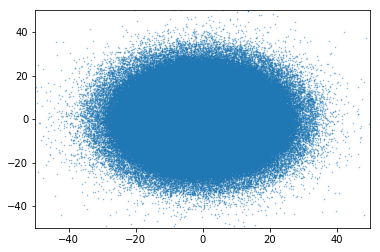

In [26]:
import matplotlib.pyplot as plt

plt.scatter(X_disk_200, Y_disk_200, s=0.3, alpha=0.5)
plt.xlim(-50,50)
plt.ylim(-50,50)

In [27]:
print(np.mean(X_disk_200))
print(np.mean(X_bulg_200))
print(np.mean(X_dm_200))

-0.0420712
-0.37511128
3.491698


In [28]:
disk_pos_200 = np.zeros((len(X_disk_200),3))
disk_pos_200[:,0] = X_disk_200
disk_pos_200[:,1] = Y_disk_200
disk_pos_200[:,2] = Z_disk_200

bulg_pos_200 = np.zeros((len(X_bulg_200),3))
bulg_pos_200[:,0] = X_bulg_200
bulg_pos_200[:,1] = Y_bulg_200
bulg_pos_200[:,2] = Z_bulg_200

dm_pos_200 = np.zeros((len(X_dm_200),3))
dm_pos_200[:,0] = X_dm_200
dm_pos_200[:,1] = Y_dm_200
dm_pos_200[:,2] = Z_dm_200

disk_vel_200 = np.zeros((len(U_disk_200),3))
disk_vel_200[:,0] = U_disk_200
disk_vel_200[:,1] = V_disk_200
disk_vel_200[:,2] = W_disk_200

bulg_vel_200 = np.zeros((len(U_bulg_200),3))
bulg_vel_200[:,0] = U_bulg_200
bulg_vel_200[:,1] = V_bulg_200
bulg_vel_200[:,2] = W_bulg_200

dm_vel_200 = np.zeros((len(U_dm_200),3))
dm_vel_200[:,0] = U_dm_200
dm_vel_200[:,1] = V_dm_200
dm_vel_200[:,2] = W_dm_200

In [29]:
import agama

agama.setUnits(mass=1, length=1, velocity=1)

dark_200 = agama.Potential(type = "Multipole",particles=(dm_pos_200, dm_mass_200),symmetry='a', gridsizeR=20, lmax=2)

disk_200 = agama.Potential(type = "CylSpline",particles=(disk_pos_200, disk_mass_200),gridsizeR=20, gridsizeZ=20,
                        mmax=0, Rmin=0.1, symmetry='a',Rmax=70, Zmin=0.02, Zmax=30)
                       
bulge_200 = agama.Potential(type = "Multipole",particles=(bulg_pos_200, bulg_mass_200),symmetry='a',gridsizeR=20,lmax=2)

In [30]:
potential_200 = agama.Potential(dark_200, disk_200, bulge_200)
af_200 = agama.ActionFinder(potential_200, interp=False)

bulgepoints_200 = np.hstack((bulg_pos_200,bulg_vel_200))
diskpoints_200 = np.hstack((disk_pos_200,disk_vel_200))
dmpoints_200 = np.hstack((dm_pos_200,dm_vel_200))

Bulg_actions_200, Bulg_angles_200, Bulg_freq_200 = af_200(bulgepoints_200, angles=True)
Disk_actions_200, Disk_angles_200, Disk_freq_200 = af_200(diskpoints_200, angles=True)
DM_actions_200, DM_angles_200, DM_freq_200 = af_200(dmpoints_200, angles=True)

In [31]:
Jrdisk_200 = Disk_actions_200[:, 0]
Jzdisk_200 = Disk_actions_200[:, 1]
Jphidisk_200 = Disk_actions_200[:, 2]

Jrbulg_200 = Bulg_actions_200[:, 0]
Jzbulg_200 = Bulg_actions_200[:, 1]
Jphibulg_200 = Bulg_actions_200[:, 2]

Jrdm_200 = DM_actions_200[:, 0]
Jzdm_200 = DM_actions_200[:, 1]
Jphidm_200 = DM_actions_200[:, 2]

Trdisk_200 = Disk_angles_200[:, 0]
Tzdisk_200 = Disk_angles_200[:, 1]
Tphidisk_200 = Disk_angles_200[:, 2]

Trbulg_200 = Bulg_angles_200[:, 0]
Tzbulg_200 = Bulg_angles_200[:, 1]
Tphibulg_200 = Bulg_angles_200[:, 2]

Trdm_200 = DM_angles_200[:, 0]
Tzdm_200 = DM_angles_200[:, 1]
Tphidm_200 = DM_angles_200[:, 2]

Ordisk_200 = Disk_freq_200[:, 0]
Ozdisk_200 = Disk_freq_200[:, 1]
Ophidisk_200 = Disk_freq_200[:, 2]

Orbulg_200 = Bulg_freq_200[:, 0]
Ozbulg_200 = Bulg_freq_200[:, 1]
Ophibulg_200 = Bulg_freq_200[:, 2]

Ordm_200 = DM_freq_200[:, 0]
Ozdm_200 = DM_freq_200[:, 1]
Ophidm_200 = DM_freq_200[:, 2]

In [32]:
from astropy.io import fits

c1 = fits.Column(name='Jr', array=np.array(Jrdisk_200), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidisk_200), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdisk_200), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdisk_200), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidisk_200), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdisk_200), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordisk_200), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidisk_200), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdisk_200), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DiskActions_200.fits')

In [33]:
c1 = fits.Column(name='Jr', array=np.array(Jrdm_200), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidm_200), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdm_200), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdm_200), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidm_200), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdm_200), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordm_200), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidm_200), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdm_200), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DMActions_200.fits')

In [34]:
c1 = fits.Column(name='Jr', array=np.array(Jrbulg_200), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphibulg_200), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzbulg_200), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trbulg_200), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphibulg_200), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzbulg_200), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Orbulg_200), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophibulg_200), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozbulg_200), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('BulgeActions_200.fits')

In [35]:
c1 = fits.Column(name='X', array=np.array(bulg_pos_200[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(bulg_pos_200[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(bulg_pos_200[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(bulg_vel_200[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(bulg_vel_200[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(bulg_vel_200[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(bulg_mass_200), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceBulge_200.fits')

In [36]:
c1 = fits.Column(name='X', array=np.array(disk_pos_200[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(disk_pos_200[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(disk_pos_200[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(disk_vel_200[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(disk_vel_200[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(disk_vel_200[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(disk_mass_200), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDisk_200.fits')

In [37]:
c1 = fits.Column(name='X', array=np.array(dm_pos_200[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(dm_pos_200[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(dm_pos_200[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(dm_vel_200[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(dm_vel_200[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(dm_vel_200[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(dm_mass_200), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDM_200.fits')

In [38]:
dm_mass_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","MASS",parttype=1)
dm_pos_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","POS ",parttype=1)
dm_vel_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","VEL ",parttype=1)

disk_mass_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","MASS",parttype=2)
disk_pos_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","POS ",parttype=2)
disk_vel_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","VEL ",parttype=2)

bulg_mass_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","MASS",parttype=3)
bulg_pos_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","POS ",parttype=3)
bulg_vel_400 =read_block("/home/douglas/Chervin/Sagittarius Snaps/snap_400","VEL ",parttype=3)


In [39]:
dm_mass_400 = dm_mass_400 * 10**10
disk_mass_400 = disk_mass_400 * 10**10
bulg_mass_400 = bulg_mass_400 * 10**10

X_dm_400 = dm_pos_400[:,0]
Y_dm_400 = dm_pos_400[:,1]
Z_dm_400 = dm_pos_400[:,2]

X_disk_400 = disk_pos_400[:,0]
Y_disk_400 = disk_pos_400[:,1]
Z_disk_400 = disk_pos_400[:,2]

X_bulg_400 = bulg_pos_400[:,0]
Y_bulg_400 = bulg_pos_400[:,1]
Z_bulg_400 = bulg_pos_400[:,2]

U_dm_400 = dm_vel_400[:,0]
V_dm_400 = dm_vel_400[:,1]
W_dm_400 = dm_vel_400[:,2]

U_disk_400 = disk_vel_400[:,0]
V_disk_400 = disk_vel_400[:,1]
W_disk_400 = disk_vel_400[:,2]

U_bulg_400 = bulg_vel_400[:,0]
V_bulg_400 = bulg_vel_400[:,1]
W_bulg_400 = bulg_vel_400[:,2]

In [40]:
print(np.mean(X_bulg_200))
print(np.mean(X_disk_200))
print(np.mean(X_dm_200))
print(np.mean(U_bulg_200))
print(np.mean(U_disk_200))
print(np.mean(U_dm_200))
print(np.mean(V_bulg_200))
print(np.mean(V_disk_200))
print(np.mean(V_dm_200))
print(np.mean(W_bulg_200))
print(np.mean(W_disk_200))
print(np.mean(W_dm_200))

-0.37511128
-0.0420712
3.491698
2.6973345
3.1318758
5.656033
-0.40101495
-0.19810818
-0.17445654
1.1666398
1.00338
8.786186


In [41]:
meanx = np.mean(X_bulg_400)
meany = np.mean(Y_bulg_400)
meanz = np.mean(Z_bulg_400)
meanu = np.mean(U_bulg_400)
meanw = np.mean(W_bulg_400)
meanxd = np.mean(X_dm_400)
meanyd = np.mean(Y_dm_400)
meanzd = np.mean(Z_dm_400)
meanud = np.mean(U_dm_400)
meanwd = np.mean(W_dm_400)

X_bulg_400 = X_bulg_400 - meanx
Y_bulg_400 = Y_bulg_400 - meany
Z_bulg_400 = Z_bulg_400 - meanz
X_disk_400 = X_disk_400 - meanx
Y_disk_400 = Y_disk_400 - meany
Z_disk_400 = Z_disk_400 - meanz
U_disk_400 = U_disk_400 - meanu
W_disk_400 = W_disk_400 - meanw
U_bulg_400 = U_bulg_400 - meanu
W_bulg_400 = W_bulg_400 - meanw
X_dm_400 = X_dm_400 - meanxd
Y_dm_400 = Y_dm_400 - meanyd
Z_dm_400 = Z_dm_400 - meanzd
U_dm_400 = U_dm_400 - meanud
W_dm_400 = W_dm_400 - meanwd

In [42]:
for i in (400,300,200,100,50,25,1,0.01,0.001):
    rho = X_bulg_400**2 + Y_bulg_400**2 + Z_bulg_400**2
    ichoose = np.where((rho<i))
    meanx = np.mean(X_bulg_400[ichoose])
    meany = np.mean(Y_bulg_400[ichoose])
    meanz = np.mean(Z_bulg_400[ichoose])
    meanu = np.mean(U_bulg_400[ichoose])
    meanw = np.mean(W_bulg_400[ichoose])

    X_bulg_400 = X_bulg_400 - meanx
    Y_bulg_400 = Y_bulg_400 - meany
    Z_bulg_400 = Z_bulg_400 - meanz
    X_disk_400 = X_disk_400 - meanx
    Y_disk_400 = Y_disk_400 - meany
    Z_disk_400 = Z_disk_400 - meanz
    U_disk_400 = U_disk_400 - meanu
    W_disk_400 = W_disk_400 - meanw
    U_bulg_400 = U_bulg_400 - meanu
    W_bulg_400 = W_bulg_400 - meanw

In [43]:
for i in (4000000, 1000000,500000, 250000, 100000,50000, 10000,1000, 100, 10, 1):
    rho = X_dm_400**2 + Y_dm_400**2 + Z_dm_400**2
    ichoose = np.where((rho<i))
    meanxd = np.mean(X_dm_400[ichoose])
    meanyd = np.mean(Y_dm_400[ichoose])
    meanzd = np.mean(Z_dm_400[ichoose])
    meanud = np.mean(U_dm_400[ichoose])
    meanwd = np.mean(W_dm_400[ichoose])
    
    X_dm_400 = X_dm_400 - meanxd
    Y_dm_400 = Y_dm_400 - meanyd
    Z_dm_400 = Z_dm_400 - meanzd
    U_dm_400 = U_dm_400 - meanud
    W_dm_400 = W_dm_400 - meanwd

In [44]:
disk_pos_400 = np.zeros((len(X_disk_400),3))
disk_pos_400[:,0] = X_disk_400
disk_pos_400[:,1] = Y_disk_400
disk_pos_400[:,2] = Z_disk_400

bulg_pos_400 = np.zeros((len(X_bulg_400),3))
bulg_pos_400[:,0] = X_bulg_400
bulg_pos_400[:,1] = Y_bulg_400
bulg_pos_400[:,2] = Z_bulg_400

dm_pos_400 = np.zeros((len(X_dm_400),3))
dm_pos_400[:,0] = X_dm_400
dm_pos_400[:,1] = Y_dm_400
dm_pos_400[:,2] = Z_dm_400

disk_vel_400 = np.zeros((len(U_disk_400),3))
disk_vel_400[:,0] = U_disk_400
disk_vel_400[:,1] = V_disk_400
disk_vel_400[:,2] = W_disk_400

bulg_vel_400 = np.zeros((len(U_bulg_400),3))
bulg_vel_400[:,0] = U_bulg_400
bulg_vel_400[:,1] = V_bulg_400
bulg_vel_400[:,2] = W_bulg_400

dm_vel_400 = np.zeros((len(U_dm_400),3))
dm_vel_400[:,0] = U_dm_400
dm_vel_400[:,1] = V_dm_400
dm_vel_400[:,2] = W_dm_400

(-50, 50)

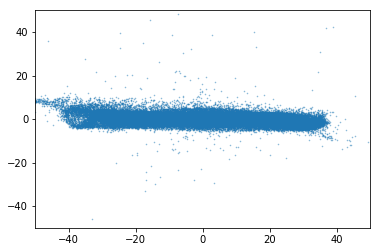

In [45]:
import matplotlib.pyplot as plt
plt.scatter(Y_disk_400,Z_disk_400, s=0.3,alpha=0.5)
plt.xlim(-50,50)
plt.ylim(-50,50)

In [46]:
agama.setUnits(mass=1, length=1, velocity=1)

dark_400 = agama.Potential(type = "Multipole",particles=(dm_pos_400, dm_mass_400),symmetry='a', gridsizeR=20, lmax=2)

disk_400 = agama.Potential(type = "CylSpline",particles=(disk_pos_400, disk_mass_400),gridsizeR=20, gridsizeZ=20,
                        mmax=0, Rmin=0.1, symmetry='a',Rmax=70, Zmin=0.02, Zmax=10)
                       
bulge_400 = agama.Potential(type = "Multipole",particles=(bulg_pos_400, bulg_mass_400),symmetry='a',gridsizeR=20,lmax=2)

In [47]:
potential_400 = agama.Potential(dark_400, disk_400, bulge_400)
af_400 = agama.ActionFinder(potential_400, interp=False)

In [48]:
bulgepoints_400 = np.hstack((bulg_pos_400,bulg_vel_400))
diskpoints_400 = np.hstack((disk_pos_400,disk_vel_400))
dmpoints_400 = np.hstack((dm_pos_400,dm_vel_400))

Bulg_actions_400, Bulg_angles_400, Bulg_freq_400 = af_400(bulgepoints_400, angles=True)
Disk_actions_400, Disk_angles_400, Disk_freq_400 = af_400(diskpoints_400, angles=True)
DM_actions_400, DM_angles_400, DM_freq_400 = af_400(dmpoints_400, angles=True)

In [49]:
Jrdisk_400 = Disk_actions_400[:, 0]
Jzdisk_400 = Disk_actions_400[:, 1]
Jphidisk_400 = Disk_actions_400[:, 2]

Jrbulg_400 = Bulg_actions_400[:, 0]
Jzbulg_400 = Bulg_actions_400[:, 1]
Jphibulg_400 = Bulg_actions_400[:, 2]

Jrdm_400 = DM_actions_400[:, 0]
Jzdm_400 = DM_actions_400[:, 1]
Jphidm_400 = DM_actions_400[:, 2]

Trdisk_400 = Disk_angles_400[:, 0]
Tzdisk_400 = Disk_angles_400[:, 1]
Tphidisk_400 = Disk_angles_400[:, 2]

Trbulg_400 = Bulg_angles_400[:, 0]
Tzbulg_400 = Bulg_angles_400[:, 1]
Tphibulg_400 = Bulg_angles_400[:, 2]

Trdm_400 = DM_angles_400[:, 0]
Tzdm_400 = DM_angles_400[:, 1]
Tphidm_400 = DM_angles_400[:, 2]

Ordisk_400 = Disk_freq_400[:, 0]
Ozdisk_400 = Disk_freq_400[:, 1]
Ophidisk_400 = Disk_freq_400[:, 2]

Orbulg_400 = Bulg_freq_400[:, 0]
Ozbulg_400 = Bulg_freq_400[:, 1]
Ophibulg_400 = Bulg_freq_400[:, 2]

Ordm_400 = DM_freq_400[:, 0]
Ozdm_400 = DM_freq_400[:, 1]
Ophidm_400 = DM_freq_400[:, 2]

In [50]:
c1 = fits.Column(name='Jr', array=np.array(Jrdisk_400), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidisk_400), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdisk_400), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdisk_400), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidisk_400), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdisk_400), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordisk_400), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidisk_400), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdisk_400), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DiskActions_400.fits')

In [51]:
c1 = fits.Column(name='Jr', array=np.array(Jrdm_400), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphidm_400), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzdm_400), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trdm_400), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphidm_400), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzdm_400), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Ordm_400), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophidm_400), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozdm_400), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('DMActions_400.fits')

In [52]:
c1 = fits.Column(name='Jr', array=np.array(Jrbulg_400), format='D', unit = 'kpc2 Myr-1')
c2 = fits.Column(name='Jphi', array=np.array(Jphibulg_400), format='D', unit = 'kpc2 Myr-1')
c3 = fits.Column(name='Jz', array=np.array(Jzbulg_400), format='D', unit ='kpc2 Myr-1')
c4 = fits.Column(name='Theta_r', array=np.array(Trbulg_400), format='D', unit = 'rad')
c5 = fits.Column(name='Theta_phi', array=np.array(Tphibulg_400), format='D', unit = 'rad')
c6 = fits.Column(name='Theta_z', array=np.array(Tzbulg_400), format='D', unit='rad')
c7 = fits.Column(name='Freq_r', array=np.array(Orbulg_400), format='D', unit='Myr-1')
c8 = fits.Column(name='Freq_phi', array=np.array(Ophibulg_400), format='D',unit='Myr-1')
c9 = fits.Column(name='Freq_z', array=np.array(Ozbulg_400), format='D', unit='Myr-1')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9])

t.writeto('BulgeActions_400.fits')

In [53]:
c1 = fits.Column(name='X', array=np.array(bulg_pos_400[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(bulg_pos_400[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(bulg_pos_400[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(bulg_vel_400[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(bulg_vel_400[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(bulg_vel_400[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(bulg_mass_400), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceBulge_400.fits')

In [54]:
c1 = fits.Column(name='X', array=np.array(disk_pos_400[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(disk_pos_400[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(disk_pos_400[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(disk_vel_400[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(disk_vel_400[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(disk_vel_400[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(disk_mass_400), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDisk_400.fits')

In [59]:
c1 = fits.Column(name='X', array=np.array(dm_pos_400[:,0]), format='D', unit = 'kpc')
c2 = fits.Column(name='Y', array=np.array(dm_pos_400[:,1]), format='D', unit = 'kpc')
c3 = fits.Column(name='Z', array=np.array(dm_pos_400[:,2]), format='D', unit ='kpc')
c4 = fits.Column(name='U', array=np.array(dm_vel_400[:,0]), format='D', unit = 'km/s')
c5 = fits.Column(name='V', array=np.array(dm_vel_400[:,1]), format='D', unit = 'km/s')
c6 = fits.Column(name='W', array=np.array(dm_vel_400[:,2]), format='D', unit='km/s')
c7 = fits.Column(name='Mass', array=np.array(dm_mass_400), format='D', unit='Solar Mass')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7])

t.writeto('PhaseSpaceDM_400.fits')

OSError: Not enough free space to write 2240000000 bytes